# 🔴 **Import Libs**

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 11.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


import cv2 as cv
import PIL
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import tqdm
import torchmetrics as tm

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, pd, cv, PIL, sklearn, torch, torchvision, tqdm, tm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.25.2
pandas --> 2.0.3
cv2 --> 4.8.0
PIL --> 9.4.0
sklearn --> 1.2.2
torch --> 2.2.1+cu121
torchvision --> 0.17.1+cu121
tqdm --> 4.66.2
torchmetrics --> 1.3.2


# 🔴 **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 **Copy & Unzip the Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xzf '/content/drive/MyDrive/Deep_learning_projects/age_estimation/data/UTKFace.tar.gz' -C '/content/'

## 🟠 EDA

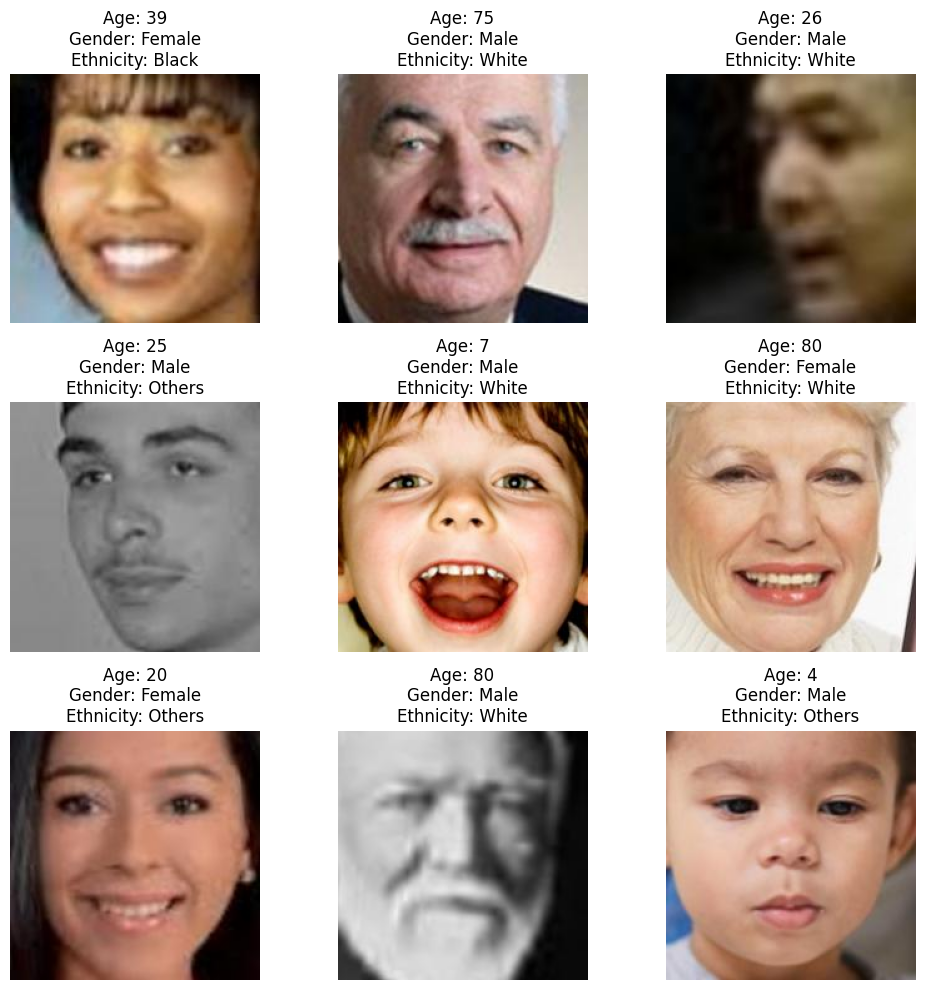

In [ ]:
# Replace with the actual path to your UTK dataset images folder
dataset_folder = '/content/UTKFace/'

def show_random_samples(num_samples=9):
    image_files = os.listdir(dataset_folder)
    selected_image_files = random.sample(image_files, num_samples)

    plt.figure(figsize=(10, 10))
    for idx, image_file in enumerate(selected_image_files, 1):
        image_path = os.path.join(dataset_folder, image_file)
        age, gender, ethnicity = image_file.split('_')[:3]

        image = Image.open(image_path)

        gender = 'Male' if int(gender) == 0 else 'Female'
        ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Others'][int(ethnicity)]

        plt.subplot(3, 3, idx)
        plt.imshow(image)
        plt.title(f"Age: {age}\nGender: {gender}\nEthnicity: {ethnicity}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display random samples
show_random_samples()


In [ ]:
import os
import pandas as pd
import re

dataset_folder = '/content/UTKFace/'
image_path = os.listdir(dataset_folder)

data = {
    'images_name': [],
    'age': [],
    'ethnicity': [],
    'gender': []
}

for item in image_path:
    parts = re.split('_', item)
    if len(parts) < 3:
        continue
    data['images_name'].append(item)
    data['age'].append(int(parts[0]))
    data['ethnicity'].append(parts[2])
    data['gender'].append(parts[1])

df = pd.DataFrame(data)

gender_mapping = {'0': 'Male', '1': 'Female'}
ethnicity_mapping = {'0': 'White', '1': 'Black', '2': 'Asian', '3': 'Indian', '4': 'Others'}

df['gender'] = df['gender'].replace(gender_mapping)
df['ethnicity'] = df['ethnicity'].replace(ethnicity_mapping)

# Filter by ethnicity
df = df[df['ethnicity'].isin(['White', 'Black', 'Indian', 'Asian', 'Others'])]

# Save the DataFrame
filepath = '/content/utkface_dataset.csv'
df.to_csv(filepath, index=False)

print(f"Dataset saved to: {filepath}")


Dataset saved to: /content/utkface_dataset.csv


In [ ]:
fig0 = px.histogram(df, x="age")
fig0.show()

In [ ]:
fig1 = px.histogram(df, x="age")
fig1.show()

In [ ]:
fig2 = px.histogram(df, x="ethnicity")
fig2.show()

In [ ]:
pd.crosstab(df.gender, df.ethnicity)

ethnicity,Asian,Black,Indian,Others,White
gender,,,,,
Female,1859,2208,1714,932,4601
Male,1575,2318,2261,760,5477


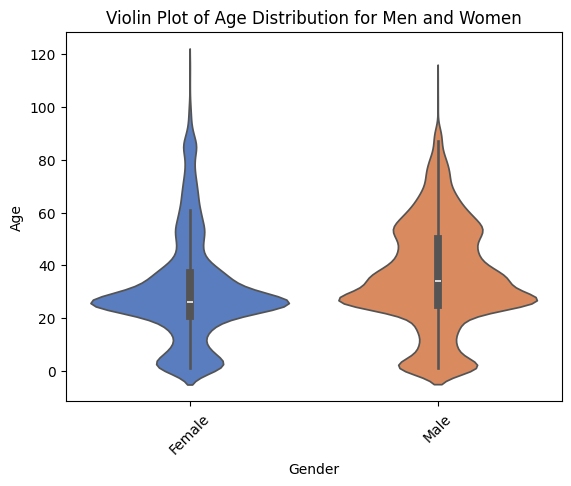

In [ ]:
sns.violinplot(
    x="gender",
    y="age",
    data=df,
    hue="gender",
    palette="muted",
)
plt.title("Violin Plot of Age Distribution for Men and Women")
plt.xlabel("Gender")
plt.ylabel("Age")
plt.xticks(rotation=45)
plt.show()


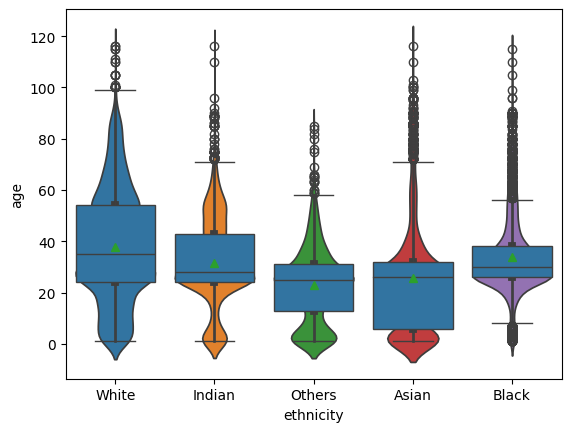

In [ ]:
sns.violinplot(x="ethnicity", y="age", data=df, hue="ethnicity")
sns.boxplot(x="ethnicity", y="age", data=df, showmeans=True)
plt.show()

## 🟠 Split datasets

In [ ]:
df_train, temp = train_test_split(df, test_size=0.3, random_state=42)
df_test, df_valid = train_test_split(temp, test_size=0.5, random_state=42)

df_train.shape, df_test.shape, df_valid.shape

((16593, 4), (3556, 4), (3556, 4))

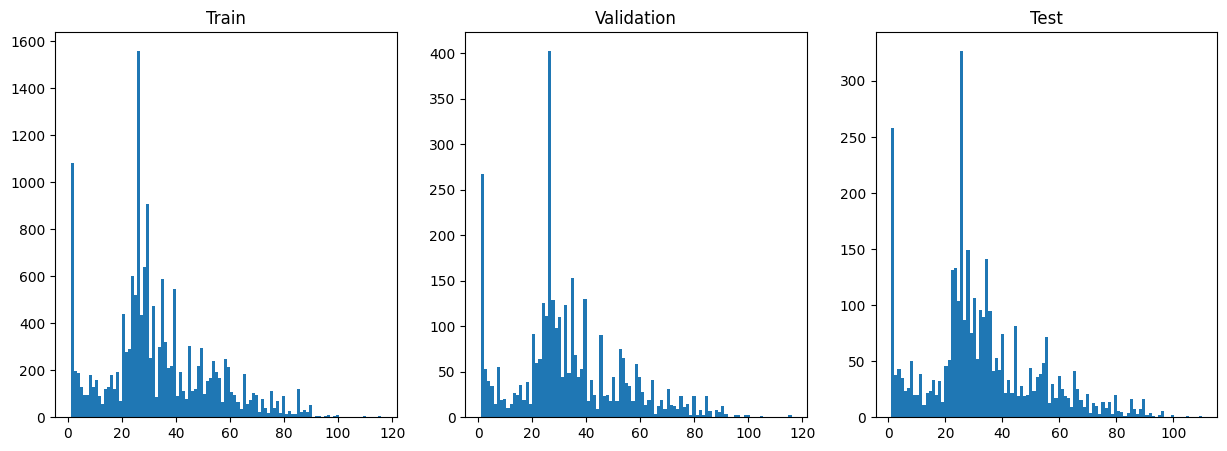

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train.age, bins=len(df_train.age.unique())); axes[0].set_title('Train')
axes[1].hist(df_valid.age, bins=len(df_valid.age.unique())); axes[1].set_title('Validation')
axes[2].hist(df_test.age, bins=len(df_test.age.unique())); axes[2].set_title('Test');

In [ ]:
df_train.to_csv('/content/train_set.csv', index=False)
df_valid.to_csv('/content/valid_set.csv', index=False)
df_test.to_csv('/content/test_set.csv', index=False)

print('All CSV files created successfully.')

All CSV files created successfully.


## 🟠 Define transformations

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## 🟠 Custom dataset

In [ ]:
class UTKDataset(Dataset):

  def __init__(self, root_dir, csv_file, transform=None):
    self.root_dir = root_dir
    self.csv_file = csv_file
    self.transform = transform
    self.data = pd.read_csv(self.csv_file)
    self.gender_mapping = {'Male': 0, 'Female': 1}
    self.ethnicity_mapping = {'White': 0, 'Black': 1, 'Asian': 2, 'Indian': 3, 'Others': 4}


  def __len__(self):
    return len(self.data)

  def __getitem__(self, index) :
        sample = self.data.iloc[index, :]
        image_name = sample.images_name
        image_path = os.path.join(self.root_dir,image_name)

        try:
            img = Image.open(image_path)
            img = self.transform(img)
        except Exception as e:
            print(f"Error loading image '{image_path}': {e}")
            return None, None, None, None
        age = torch.tensor([sample.age], dtype=torch.float32)
        ethnicity = torch.tensor(self.ethnicity_mapping[sample.ethnicity], dtype=torch.int32)
        gender = torch.tensor(self.gender_mapping[sample.gender], dtype=torch.int32)


        return img, age#, gender, ethnicity

In [ ]:
train_dataset = UTKDataset('/content/UTKFace', csv_file= '/content/train_set.csv', transform=train_transform)
valid_dataset = UTKDataset('/content/UTKFace', csv_file= '/content/valid_set.csv', transform=test_transform)
test_dataset = UTKDataset('/content/UTKFace', csv_file= '/content/test_set.csv', transform=test_transform)

In [ ]:
img,age = test_dataset[10]
print(age)
# print(gender)
# print(ethnicity)
img

tensor([52.])


tensor([[[ 1.1700,  1.0331,  0.8447,  ...,  1.8208,  1.8379,  1.7523],
         [ 1.0673,  0.9817,  0.8789,  ...,  1.8379,  1.8379,  1.7180],
         [ 0.9988,  0.9303,  0.9132,  ...,  1.8037,  1.8208,  1.7180],
         ...,
         [ 1.2728,  1.1187,  0.9988,  ...,  0.5364,  0.5536,  0.7591],
         [ 1.2899,  1.1529,  0.9988,  ...,  0.4508,  0.4679,  0.6734],
         [ 1.3070,  1.1700,  0.9817,  ...,  0.3652,  0.3994,  0.6049]],

        [[ 0.9230,  0.7829,  0.5728,  ...,  1.5882,  1.5882,  1.5007],
         [ 0.8179,  0.7304,  0.6078,  ...,  1.6057,  1.5882,  1.4657],
         [ 0.7304,  0.6604,  0.6429,  ...,  1.5882,  1.5707,  1.4657],
         ...,
         [ 0.8179,  0.6604,  0.5378,  ...,  0.0126,  0.0301,  0.2402],
         [ 0.8354,  0.6954,  0.5378,  ..., -0.0574, -0.0574,  0.1527],
         [ 0.8529,  0.7129,  0.5203,  ..., -0.1450, -0.1275,  0.0826]],

        [[ 0.3742,  0.2348,  0.0605,  ...,  1.3502,  1.3328,  1.2282],
         [ 0.2871,  0.1999,  0.1128,  ...,  1

## 🟠 Define dataloader

In [ ]:
trainloader = DataLoader(dataset=train_dataset ,batch_size=128, shuffle=True,  num_workers=2)
validloader = DataLoader(dataset=valid_dataset ,batch_size=256, shuffle=True,  num_workers=2)
testloader = DataLoader(dataset=test_dataset ,batch_size=256, shuffle=True,  num_workers=2)

In [ ]:
img,age= next(iter(trainloader))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



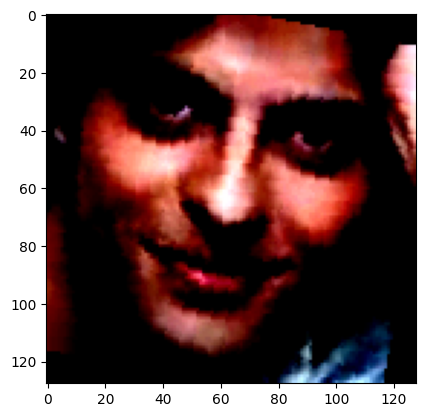

In [ ]:
plt.imshow(img[17].permute(1, 2, 0))

# 🔴 **Model**

In [ ]:
class AgeEstimationModel(nn.Module):
  def __init__(self):
     super().__init__()
     self.resnet = models.resnet50(weights = models.ResNet50_Weights.IMAGENET1K_V2)
     self.resnet.fc = nn.LazyLinear(out_features = 1, bias = True)


  def forward(self, x):
    pred = self.resnet(x)
    return pred

In [ ]:
Model = AgeEstimationModel()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning:

Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.



# 🔴 **Config**

In [ ]:
loss_fn = nn.L1Loss()

optimizer = optim.SGD(Model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

metric = tm.MeanAbsoluteError().to(device)


# 🔴 **Train**

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

# 🔴 **Training Process**

## 🟠 Finding Hyper-parameters

In [ ]:
model = AgeEstimationModel().to(device)

inputs, targets = next(iter(trainloader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs, targets)

print(loss)

tensor(34.1117, device='cuda:0')


In [ ]:
mini_train_size = 1000
_, mini_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
model = AgeEstimationModel().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, epoch)

In [ ]:
num_epochs = 3

for lr in [0.1, 0.01, 0.001, 0.0001]:
  print(f'LR={lr}')

  model = AgeEstimationModel().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

In [ ]:
num_epochs = 5

for lr in [0.005, 0.003, 0.001, 0.0007, 0.0005]:
  for wd in [1e-4, 1e-5, 0.]:
    print(f'LR={lr}, WD={wd}')

    model = AgeEstimationModel().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

    print()

## 🟠 Main Loop

In [ ]:
model = AgeEstimationModel().to(device)

In [ ]:
optimizer = optim.SGD(model.parameters(),lr = 0.001, weight_decay=1e-4, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

num_epochs = 50

for epoch in range(num_epochs):

  model, lossTrain, MetricTrain = train_one_epoch(model, trainloader, loss_fn, optimizer, metric, epoch)

  model, lossValid, MetricValid = train_one_epoch(model, validloader, loss_fn, optimizer, metric, epoch)

  loss_train_hist.append(lossTrain)
  loss_valid_hist.append(lossValid)

  metric_train_hist.append(MetricTrain)
  metric_valid_hist.append(MetricValid)


  if lossValid < best_loss_valid:
    torch.save(model, f"model_{epoch+1}.pt")
    best_loss_valid = lossValid
    print(f'Model saved at epoch {epoch_counter} with validation loss {lossValid:.4f}')

  print(f'Epoch {epoch+1}/{num_epochs}: Train Loss = {lossTrain:.4f}, Train Metric = {MetricTrain:.4f}')
  print(f'                  Valid Loss = {lossValid:.4f}, Valid Metric = {MetricValid:.4f}')
  print("-" * 50)

  epoch_counter += 1

100%|██████████| 14/14 [00:13<00:00,  1.06batch/s, loss=7.46, metric=7.46]


Model saved at epoch 0 with validation loss 7.4637
Epoch 1/50: Train Loss = 16.2856, Train Metric = 16.2856
                  Valid Loss = 7.4637, Valid Metric = 7.4637
--------------------------------------------------


Epoch 1: 100%|██████████| 14/14 [00:13<00:00,  1.03batch/s, loss=6.13, metric=6.13]


Model saved at epoch 1 with validation loss 6.1332
Epoch 2/50: Train Loss = 6.9970, Train Metric = 6.9970
                  Valid Loss = 6.1332, Valid Metric = 6.1332
--------------------------------------------------


Epoch 2: 100%|██████████| 14/14 [00:14<00:00,  1.00s/batch, loss=5.05, metric=5.05]


Model saved at epoch 2 with validation loss 5.0531
Epoch 3/50: Train Loss = 6.1607, Train Metric = 6.1607
                  Valid Loss = 5.0531, Valid Metric = 5.0531
--------------------------------------------------


Epoch 3: 100%|██████████| 14/14 [00:13<00:00,  1.01batch/s, loss=4.68, metric=4.68]


Model saved at epoch 3 with validation loss 4.6778
Epoch 4/50: Train Loss = 5.6634, Train Metric = 5.6634
                  Valid Loss = 4.6778, Valid Metric = 4.6778
--------------------------------------------------


Epoch 4: 100%|██████████| 14/14 [00:13<00:00,  1.03batch/s, loss=4.32, metric=4.32]


Model saved at epoch 4 with validation loss 4.3217
Epoch 5/50: Train Loss = 5.4707, Train Metric = 5.4707
                  Valid Loss = 4.3217, Valid Metric = 4.3217
--------------------------------------------------


Epoch 5: 100%|██████████| 14/14 [00:13<00:00,  1.04batch/s, loss=4.17, metric=4.17]


Model saved at epoch 5 with validation loss 4.1727
Epoch 6/50: Train Loss = 5.1726, Train Metric = 5.1726
                  Valid Loss = 4.1727, Valid Metric = 4.1727
--------------------------------------------------


Epoch 6: 100%|██████████| 14/14 [00:13<00:00,  1.03batch/s, loss=3.72, metric=3.72]


Model saved at epoch 6 with validation loss 3.7228
Epoch 7/50: Train Loss = 4.9414, Train Metric = 4.9414
                  Valid Loss = 3.7228, Valid Metric = 3.7228
--------------------------------------------------


Epoch 7: 100%|██████████| 14/14 [00:13<00:00,  1.02batch/s, loss=3.6, metric=3.6]


Model saved at epoch 7 with validation loss 3.5986
Epoch 8/50: Train Loss = 4.7417, Train Metric = 4.7417
                  Valid Loss = 3.5986, Valid Metric = 3.5986
--------------------------------------------------


Epoch 8: 100%|██████████| 14/14 [00:13<00:00,  1.00batch/s, loss=3.44, metric=3.44]


Model saved at epoch 8 with validation loss 3.4371
Epoch 9/50: Train Loss = 4.5600, Train Metric = 4.5600
                  Valid Loss = 3.4371, Valid Metric = 3.4371
--------------------------------------------------


Epoch 9: 100%|██████████| 14/14 [00:14<00:00,  1.01s/batch, loss=3.25, metric=3.25]


Model saved at epoch 9 with validation loss 3.2513
Epoch 10/50: Train Loss = 4.4651, Train Metric = 4.4651
                  Valid Loss = 3.2513, Valid Metric = 3.2513
--------------------------------------------------


Epoch 10: 100%|██████████| 14/14 [00:13<00:00,  1.05batch/s, loss=2.98, metric=2.98]


Model saved at epoch 10 with validation loss 2.9781
Epoch 11/50: Train Loss = 4.3190, Train Metric = 4.3190
                  Valid Loss = 2.9781, Valid Metric = 2.9781
--------------------------------------------------


Epoch 11: 100%|██████████| 14/14 [00:13<00:00,  1.03batch/s, loss=2.8, metric=2.8]


Model saved at epoch 11 with validation loss 2.8003
Epoch 12/50: Train Loss = 4.2001, Train Metric = 4.2001
                  Valid Loss = 2.8003, Valid Metric = 2.8003
--------------------------------------------------


Epoch 12: 100%|██████████| 14/14 [00:13<00:00,  1.03batch/s, loss=2.72, metric=2.72]


Model saved at epoch 12 with validation loss 2.7237
Epoch 13/50: Train Loss = 4.0396, Train Metric = 4.0396
                  Valid Loss = 2.7237, Valid Metric = 2.7237
--------------------------------------------------


Epoch 13: 100%|██████████| 14/14 [00:13<00:00,  1.01batch/s, loss=2.61, metric=2.61]


Model saved at epoch 13 with validation loss 2.6109
Epoch 14/50: Train Loss = 3.9336, Train Metric = 3.9336
                  Valid Loss = 2.6109, Valid Metric = 2.6109
--------------------------------------------------


Epoch 14: 100%|██████████| 14/14 [00:14<00:00,  1.01s/batch, loss=2.61, metric=2.61]


Epoch 15/50: Train Loss = 3.8726, Train Metric = 3.8726
                  Valid Loss = 2.6118, Valid Metric = 2.6118
--------------------------------------------------


Epoch 15: 100%|██████████| 14/14 [00:14<00:00,  1.01s/batch, loss=2.62, metric=2.62]


Epoch 16/50: Train Loss = 3.8277, Train Metric = 3.8277
                  Valid Loss = 2.6245, Valid Metric = 2.6245
--------------------------------------------------


Epoch 16: 100%|██████████| 14/14 [00:13<00:00,  1.05batch/s, loss=2.37, metric=2.37]


Model saved at epoch 16 with validation loss 2.3745
Epoch 17/50: Train Loss = 3.7360, Train Metric = 3.7360
                  Valid Loss = 2.3745, Valid Metric = 2.3745
--------------------------------------------------


Epoch 17: 100%|██████████| 14/14 [00:13<00:00,  1.03batch/s, loss=2.34, metric=2.34]


Model saved at epoch 17 with validation loss 2.3358
Epoch 18/50: Train Loss = 3.5987, Train Metric = 3.5987
                  Valid Loss = 2.3358, Valid Metric = 2.3358
--------------------------------------------------


Epoch 18: 100%|██████████| 14/14 [00:13<00:00,  1.00batch/s, loss=2.28, metric=2.28]


Model saved at epoch 18 with validation loss 2.2784
Epoch 19/50: Train Loss = 3.5220, Train Metric = 3.5220
                  Valid Loss = 2.2784, Valid Metric = 2.2784
--------------------------------------------------


Epoch 19: 100%|██████████| 14/14 [00:13<00:00,  1.04batch/s, loss=2.32, metric=2.32]


Epoch 20/50: Train Loss = 3.4837, Train Metric = 3.4837
                  Valid Loss = 2.3221, Valid Metric = 2.3221
--------------------------------------------------


Epoch 20: 100%|██████████| 14/14 [00:13<00:00,  1.03batch/s, loss=2.18, metric=2.18]


Model saved at epoch 20 with validation loss 2.1799
Epoch 21/50: Train Loss = 3.3684, Train Metric = 3.3684
                  Valid Loss = 2.1799, Valid Metric = 2.1799
--------------------------------------------------


Epoch 21: 100%|██████████| 14/14 [00:13<00:00,  1.01batch/s, loss=2.05, metric=2.05]


Model saved at epoch 21 with validation loss 2.0494
Epoch 22/50: Train Loss = 3.3299, Train Metric = 3.3299
                  Valid Loss = 2.0494, Valid Metric = 2.0494
--------------------------------------------------


Epoch 22: 100%|██████████| 14/14 [00:13<00:00,  1.05batch/s, loss=2.02, metric=2.02]


Model saved at epoch 22 with validation loss 2.0233
Epoch 23/50: Train Loss = 3.2068, Train Metric = 3.2068
                  Valid Loss = 2.0233, Valid Metric = 2.0233
--------------------------------------------------


Epoch 23: 100%|██████████| 14/14 [00:13<00:00,  1.03batch/s, loss=2.08, metric=2.08]


Epoch 24/50: Train Loss = 3.1986, Train Metric = 3.1986
                  Valid Loss = 2.0792, Valid Metric = 2.0792
--------------------------------------------------


Epoch 24: 100%|██████████| 14/14 [00:13<00:00,  1.02batch/s, loss=2.07, metric=2.07]


Epoch 25/50: Train Loss = 3.1011, Train Metric = 3.1011
                  Valid Loss = 2.0653, Valid Metric = 2.0653
--------------------------------------------------


Epoch 25: 100%|██████████| 14/14 [00:14<00:00,  1.01s/batch, loss=1.93, metric=1.93]


Model saved at epoch 25 with validation loss 1.9253
Epoch 26/50: Train Loss = 3.0389, Train Metric = 3.0389
                  Valid Loss = 1.9253, Valid Metric = 1.9253
--------------------------------------------------


Epoch 26: 100%|██████████| 14/14 [00:14<00:00,  1.00s/batch, loss=1.94, metric=1.94]


Epoch 27/50: Train Loss = 2.9925, Train Metric = 2.9925
                  Valid Loss = 1.9439, Valid Metric = 1.9439
--------------------------------------------------


Epoch 27: 100%|██████████| 14/14 [00:13<00:00,  1.04batch/s, loss=1.93, metric=1.93]


Epoch 28/50: Train Loss = 2.9160, Train Metric = 2.9160
                  Valid Loss = 1.9297, Valid Metric = 1.9297
--------------------------------------------------


Epoch 28: 100%|██████████| 14/14 [00:13<00:00,  1.02batch/s, loss=1.84, metric=1.84]


Model saved at epoch 28 with validation loss 1.8446
Epoch 29/50: Train Loss = 2.8208, Train Metric = 2.8208
                  Valid Loss = 1.8446, Valid Metric = 1.8446
--------------------------------------------------


Epoch 29: 100%|██████████| 14/14 [00:14<00:00,  1.00s/batch, loss=1.9, metric=1.9]


Epoch 30/50: Train Loss = 2.8923, Train Metric = 2.8923
                  Valid Loss = 1.8985, Valid Metric = 1.8985
--------------------------------------------------


Epoch 30: 100%|██████████| 14/14 [00:13<00:00,  1.01batch/s, loss=1.79, metric=1.79]


Model saved at epoch 30 with validation loss 1.7933
Epoch 31/50: Train Loss = 2.7602, Train Metric = 2.7602
                  Valid Loss = 1.7933, Valid Metric = 1.7933
--------------------------------------------------


Epoch 31: 100%|██████████| 14/14 [00:13<00:00,  1.04batch/s, loss=1.79, metric=1.79]


Model saved at epoch 31 with validation loss 1.7927
Epoch 32/50: Train Loss = 2.6784, Train Metric = 2.6784
                  Valid Loss = 1.7927, Valid Metric = 1.7927
--------------------------------------------------


Epoch 32: 100%|██████████| 14/14 [00:13<00:00,  1.03batch/s, loss=1.69, metric=1.69]


Model saved at epoch 32 with validation loss 1.6863
Epoch 33/50: Train Loss = 2.6327, Train Metric = 2.6327
                  Valid Loss = 1.6863, Valid Metric = 1.6863
--------------------------------------------------


Epoch 33: 100%|██████████| 14/14 [00:13<00:00,  1.02batch/s, loss=1.63, metric=1.63]


Model saved at epoch 33 with validation loss 1.6264
Epoch 34/50: Train Loss = 2.6258, Train Metric = 2.6258
                  Valid Loss = 1.6264, Valid Metric = 1.6264
--------------------------------------------------


Epoch 34: 100%|██████████| 14/14 [00:14<00:00,  1.01s/batch, loss=1.65, metric=1.65]


Epoch 35/50: Train Loss = 2.5458, Train Metric = 2.5458
                  Valid Loss = 1.6509, Valid Metric = 1.6509
--------------------------------------------------


Epoch 35: 100%|██████████| 14/14 [00:13<00:00,  1.01batch/s, loss=1.6, metric=1.6]


Model saved at epoch 35 with validation loss 1.6049
Epoch 36/50: Train Loss = 2.5183, Train Metric = 2.5183
                  Valid Loss = 1.6049, Valid Metric = 1.6049
--------------------------------------------------


Epoch 36: 100%|██████████| 14/14 [00:13<00:00,  1.06batch/s, loss=1.56, metric=1.56]


Model saved at epoch 36 with validation loss 1.5558
Epoch 37/50: Train Loss = 2.4371, Train Metric = 2.4371
                  Valid Loss = 1.5558, Valid Metric = 1.5558
--------------------------------------------------


Epoch 37: 100%|██████████| 14/14 [00:13<00:00,  1.04batch/s, loss=1.57, metric=1.57]


Epoch 38/50: Train Loss = 2.4308, Train Metric = 2.4308
                  Valid Loss = 1.5738, Valid Metric = 1.5738
--------------------------------------------------


Epoch 38: 100%|██████████| 14/14 [00:13<00:00,  1.02batch/s, loss=1.53, metric=1.53]


Model saved at epoch 38 with validation loss 1.5314
Epoch 39/50: Train Loss = 2.3815, Train Metric = 2.3815
                  Valid Loss = 1.5314, Valid Metric = 1.5314
--------------------------------------------------


Epoch 39: 100%|██████████| 14/14 [00:13<00:00,  1.01batch/s, loss=1.51, metric=1.51]


Model saved at epoch 39 with validation loss 1.5148
Epoch 40/50: Train Loss = 2.3296, Train Metric = 2.3296
                  Valid Loss = 1.5148, Valid Metric = 1.5148
--------------------------------------------------


Epoch 40: 100%|██████████| 14/14 [00:14<00:00,  1.00s/batch, loss=1.63, metric=1.63]


Epoch 41/50: Train Loss = 2.3213, Train Metric = 2.3213
                  Valid Loss = 1.6262, Valid Metric = 1.6262
--------------------------------------------------


Epoch 41: 100%|██████████| 14/14 [00:13<00:00,  1.04batch/s, loss=1.52, metric=1.52]


Epoch 42/50: Train Loss = 2.2454, Train Metric = 2.2454
                  Valid Loss = 1.5182, Valid Metric = 1.5182
--------------------------------------------------


Epoch 42: 100%|██████████| 14/14 [00:13<00:00,  1.03batch/s, loss=1.43, metric=1.43]


Model saved at epoch 42 with validation loss 1.4343
Epoch 43/50: Train Loss = 2.2302, Train Metric = 2.2302
                  Valid Loss = 1.4343, Valid Metric = 1.4343
--------------------------------------------------


Epoch 43: 100%|██████████| 14/14 [00:13<00:00,  1.02batch/s, loss=1.41, metric=1.41]


Model saved at epoch 43 with validation loss 1.4113
Epoch 44/50: Train Loss = 2.2000, Train Metric = 2.2000
                  Valid Loss = 1.4113, Valid Metric = 1.4113
--------------------------------------------------


Epoch 44: 100%|██████████| 14/14 [00:14<00:00,  1.00s/batch, loss=1.44, metric=1.44]


Epoch 45/50: Train Loss = 2.1962, Train Metric = 2.1962
                  Valid Loss = 1.4428, Valid Metric = 1.4428
--------------------------------------------------


Epoch 45: 100%|██████████| 14/14 [00:14<00:00,  1.00s/batch, loss=1.43, metric=1.43]


Epoch 46/50: Train Loss = 2.1149, Train Metric = 2.1149
                  Valid Loss = 1.4316, Valid Metric = 1.4316
--------------------------------------------------


Epoch 46: 100%|██████████| 14/14 [00:13<00:00,  1.05batch/s, loss=1.37, metric=1.37]


Model saved at epoch 46 with validation loss 1.3656
Epoch 47/50: Train Loss = 2.0902, Train Metric = 2.0902
                  Valid Loss = 1.3656, Valid Metric = 1.3656
--------------------------------------------------


Epoch 47: 100%|██████████| 14/14 [00:13<00:00,  1.04batch/s, loss=1.41, metric=1.41]


Epoch 48/50: Train Loss = 2.0777, Train Metric = 2.0777
                  Valid Loss = 1.4146, Valid Metric = 1.4146
--------------------------------------------------


Epoch 48: 100%|██████████| 14/14 [00:13<00:00,  1.02batch/s, loss=1.3, metric=1.3]


Model saved at epoch 48 with validation loss 1.3010
Epoch 49/50: Train Loss = 2.0597, Train Metric = 2.0597
                  Valid Loss = 1.3010, Valid Metric = 1.3010
--------------------------------------------------


Epoch 49: 100%|██████████| 14/14 [00:14<00:00,  1.01s/batch, loss=1.36, metric=1.36]

Epoch 50/50: Train Loss = 2.0881, Train Metric = 2.0881
                  Valid Loss = 1.3554, Valid Metric = 1.3554
--------------------------------------------------


## 🟠 Plot

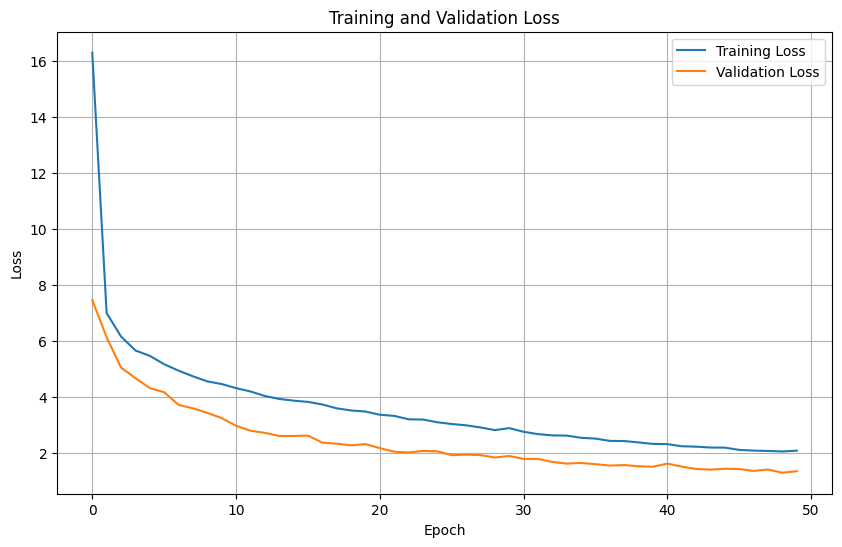

In [ ]:
epochs = range(epoch_counter)

plt.figure(figsize=(10, 6))

plt.plot(epochs, loss_train_hist, label='Training Loss')
plt.plot(epochs, loss_valid_hist, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.grid(True)
plt.legend()
plt.show()

# 🔴 **Test**

In [ ]:
model_t = torch.load("/content/drive/MyDrive/Deep_learning_projects/age_estimation/model_49.pt")
model_t.eval()

train_loss,train_metric = evaluate(model_t, trainloader, loss_fn, metric)

valid_loss,valid_metric = evaluate(model_t, validloader, loss_fn, metric)

test_loss,test_metric = evaluate(model_t, testloader, loss_fn, metric)

In [ ]:
train_metric,valid_metric,test_metric

(2.734724998474121, 2.1770131587982178, 2.179381847381592)

# 🔴 **Inference**

tensor([[24.8042]], device='cuda:0')


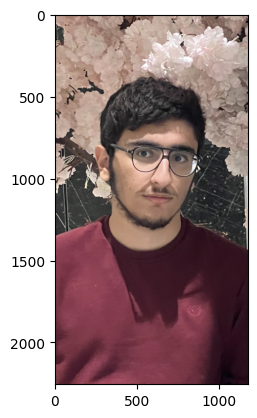

In [ ]:
model = torch.load("/content/drive/MyDrive/Deep_learning_projects/age_estimation/model_49.pt")


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_path = "/content/IMG_6083.JPG"
image = Image.open(image_path).convert("RGB")

image_tensor = transform(image).unsqueeze(0)

image_tensor = image_tensor.to(device)

with torch.no_grad():
    predictions = model(image_tensor)

print(predictions)
plt.imshow(image)